In [35]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Viktor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
train = pd.read_csv("C:\\Users\\Viktor\\Desktop\\Spooky_Authors\\train.csv", index_col=['id'])
test = pd.read_csv("C:\\Users\\Viktor\\Desktop\\Spooky_Authors\\test.csv", index_col=['id'])
sample_submission = pd.read_csv("C:\\Users\\Viktor\\Desktop\\Spooky_Authors\\sample_submission.csv", index_col=['id'])

print(train.shape, test.shape, sample_submission.shape)
print(set(train.columns) - set(test.columns))

(19579, 2) (8392, 1) (8392, 3)
{'author'}


In [43]:
train.head(5)

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


In [44]:
percent_missing = 100 * train.isnull().sum()/len(train)

In [45]:
percent_missing

text      0.0
author    0.0
dtype: float64

In [46]:
# look at class imbalance

eap = (train.author == 'EAP').sum()
hpl = (train.author == 'HPL').sum()
mws = (train.author == 'MWS').sum()
print(eap, hpl, mws)

7900 5635 6044


In [47]:
train.author = train.author.replace(['EAP', 'HPL', 'MWS'], ['Едгар', 'Хауърд', 'Мери'])

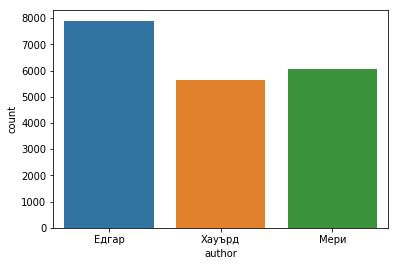

In [48]:
sns.countplot(data=train, x='author');

In [49]:
all_words = train['text'].str.split(expand=True).unstack().value_counts()
all_words.head(10)

the     33296
of      20851
and     17059
to      12615
I       10382
a       10359
in       8787
was      6440
that     5988
my       5037
dtype: int64

In [50]:
train_corpus = []
for i in range(len(train)):
    review = re.sub('[^a-zA-Z0-9]', ' ', train['text'][i])
    review = review.lower()
    review = review.split()
    review = [word for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    train_corpus.append(review)

In [51]:
test_corpus = []
for i in range(len(test)):
    review = re.sub('[^a-zA-Z0-9]', ' ', test['text'][i])
    review = review.lower()
    review = review.split()
    review = [word for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    test_corpus.append(review)


In [58]:
# format data for input
X_Train = np.array(train_corpus)
X_Test = np.array(test_corpus)
y = train.iloc[:, 1].values

In [67]:
## Multinomial Naive Bayes Classifier ##
# Build pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
classifier = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
])
classifier.fit(X_Train, y)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [69]:
# parameter tuning with grid search
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (0, 0.01, 0.05, 0.1, 0.3, 0.5),
}
model = GridSearchCV(classifier, parameters)
model.fit(X_Train, y)

c:\users\viktor\anaconda3\envs\tensorflow\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
c:\users\viktor\anaconda3\envs\tensorflow\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
c:\users\viktor\anaconda3\envs\tensorflow\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
c:\users\viktor\anaconda3\envs\tensorflow\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
c:\users\viktor\anaconda3\envs\tensorflow\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting 

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vect__ngram_range': [(1, 1), (1, 2), (1, 3)], 'tfidf__use_idf': (True, False), 'clf__alpha': (0, 0.01, 0.05, 0.1, 0.3, 0.5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [70]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, train.text, train.author, cv=3, n_jobs=3)

array([0.85094975, 0.84891204, 0.84858238])